In [ ]:
import pandas as pd
import numpy as np
import time

data = pd.read_excel('gasstationdata33.xlsx')
data.describe()

In [ ]:
arrivals = data["Arrival Time"]

fuel_time = data["Service time Fuel"]
shop_time = data["Shop time"]
payment_time = data["Service time payment"]

In [37]:
print(arrivals[0], arrivals[1], arrivals[2])

import pandas as pd

# Convert timestamps to datetime objects
arrivals_datetime = [arrival.to_pydatetime() for arrival in arrivals]

# make a datetime object for 2024-02-01 at 06:00:00
start_time = pd.to_datetime('2024-02-01 06:00:00')

print(arrivals_datetime[0])

# Calculate interarrival times in minutes
interarrival_times = [(arrivals_datetime[i] - arrivals_datetime[i-1]).total_seconds() / 60 if i != 0 else 
                      (arrivals_datetime[0] - start_time).total_seconds() / 60 for i in range(len(arrivals_datetime))]

print("Interarrival Times (in minutes):", interarrival_times)


2024-02-01 06:00:06.644000 2024-02-01 06:03:05.847000 2024-02-01 06:05:45.348000
2024-02-01 06:00:06.644000
Interarrival Times (in minutes): [0.11073333333333334, 2.9867166666666667, 2.65835, 1.7679666666666667, 7.943516666666667, 1.5156999999999998, 2.78795, 1.5053833333333333, 0.6180333333333333, 4.078516666666667, 1.29055, 0.09558333333333334, 0.0682, 0.69645, 0.1232, 0.91315, 1.7561666666666667, 0.13848333333333332, 2.5885166666666666, 2.4811833333333335, 1.5362833333333334, 0.03253333333333333, 5.831083333333334, 0.6334, 4.422333333333333, 8.3561, 2.656, 1.0834833333333334, 0.7053833333333334, 1.7998, 5.816083333333333, 0.7722333333333334, 0.46476666666666666, 0.29261666666666664, 7.2543, 5.738883333333334, 5.876783333333334, 2.8013166666666667, 8.801783333333333, 2.1713, 1.1534499999999999, 6.4944, 0.3862833333333333, 3.21845, 0.49198333333333333, 3.10005, 0.15475, 0.0559, 2.4139166666666667, 0.2659333333333333, 5.474716666666667, 2.483166666666667, 0.60505, 0.39885000000000004, 

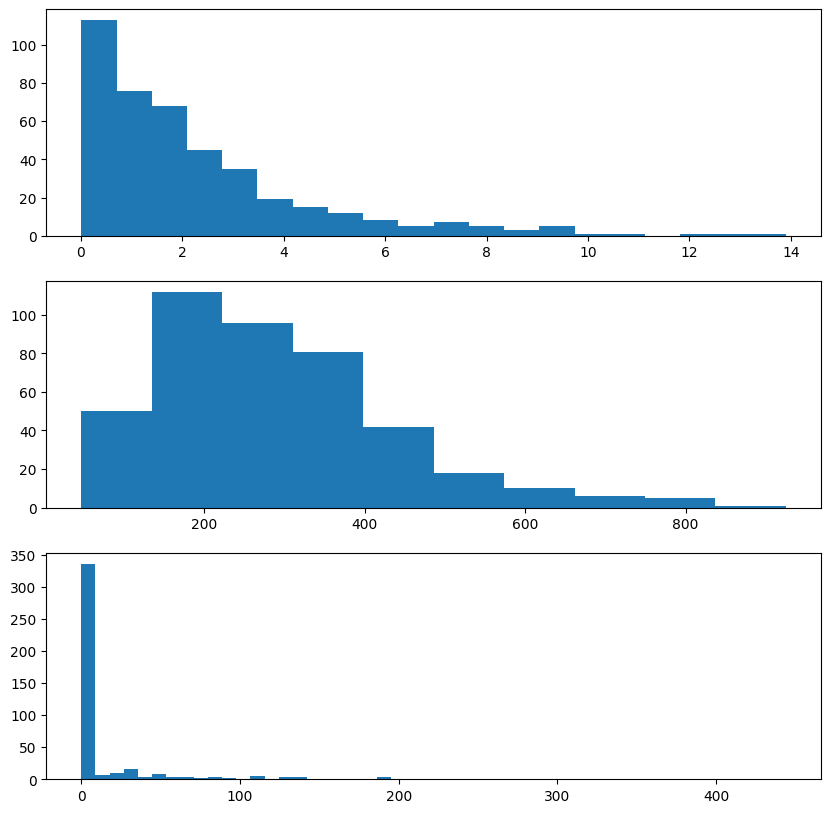

In [38]:
# a figure with 3 subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].hist(interarrival_times, bins=20)
axs[1].hist(fuel_time, bins=10)
axs[2].hist(shop_time, bins=50)

# show the plot
plt.show()